In [1]:
#Import needed packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import decomposition, datasets, tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

Data set https://www.kaggle.com/datasets/hemendrasr/name-by-nationality?resource=download

## Data Exploration

In [2]:
# Read in the data
name_nation_data = pd.read_csv('./names-by-nationality.csv')

In [3]:
name_nation_data.head()

,name,sex,nationality
0,Aarav,Male,Indian
1,Aaryan,Male,Indian
2,Abha,Female,Indian
3,Abhay,Male,Indian
4,Abhilash,Male,Indian


In [4]:
name_nation_data.shape

(4695, 3)

In [5]:
name_nation_data.sample(n=25, random_state=20)

,name,sex,nationality
2021,Archie,Male,German
3092,Brandissa,Female,American
2337,Aimon,Male,French
2992,Aniston,Neutral,American
1564,Chiazam,Male,African
1420,Yasushi,Male,Japanese
3013,Arisha,Female,American
2360,Anatole,Male,French
4521,Tariana,Female,American
3035,Audriana,Female,American


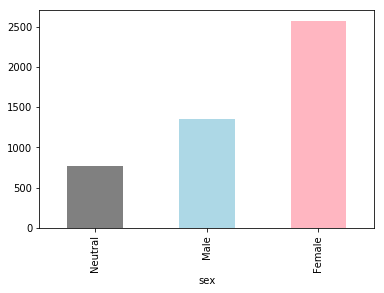

Female     2573
Male       1356
Neutral     766
Name: sex, dtype: int64

In [6]:
#Distribution of the genders
(name_nation_data.groupby(['sex']).size().sort_values()).plot(kind='bar', color=['gray','lightblue','lightpink'])
plt.show()
name_nation_data['sex'].value_counts()

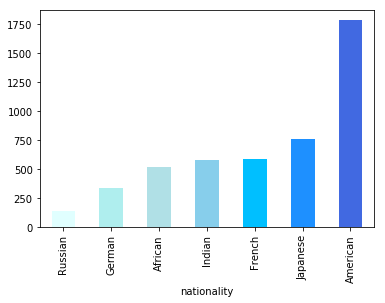

American    1782
Japanese     757
French       584
Indian       576
African      520
German       334
Russian      142
Name: nationality, dtype: int64

In [7]:
# Distribution of the nationalities
(name_nation_data.groupby(['nationality']).size().sort_values()).plot(kind='bar', color=['lightcyan','paleturquoise','powderblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue'])
plt.show()
name_nation_data['nationality'].value_counts()

## Data Processing 

In [60]:
#Split the dataframe into response and explanatory variables
X = name_nation_data["name"].tolist()
labels = name_nation_data["nationality"].tolist()

In [61]:
def tokenize(names):
    '''
    This function takes the names as strings. It cleans them and splits them into letters 
    
    Input: names - list of strings to be cleaned and split
    
    Output: lettered - List of the letters in each name
    '''
    
    lettered = []
    for i in names:
        lettered.append([x for x in i])
        
    return lettered

In [62]:
X[:10]

['Aarav',
 'Aaryan',
 'Abha',
 'Abhay',
 'Abhilash',
 'Abhilasha',
 'Abhinav',
 'Adarsh',
 'Adit',
 'Adita']

In [63]:
l = tokenize(X)
l[:10]

[['A', 'a', 'r', 'a', 'v'],
 ['A', 'a', 'r', 'y', 'a', 'n'],
 ['A', 'b', 'h', 'a'],
 ['A', 'b', 'h', 'a', 'y'],
 ['A', 'b', 'h', 'i', 'l', 'a', 's', 'h'],
 ['A', 'b', 'h', 'i', 'l', 'a', 's', 'h', 'a'],
 ['A', 'b', 'h', 'i', 'n', 'a', 'v'],
 ['A', 'd', 'a', 'r', 's', 'h'],
 ['A', 'd', 'i', 't'],
 ['A', 'd', 'i', 't', 'a']]

In [98]:
allLetters = [item for sublist in l for item in sublist]

In [99]:
# seeing the prevelence of the letters
pd.Series(allLetters).value_counts()

a    4542
e    2885
i    2712
n    2335
r    1753
l    1549
o    1480
s    1336
t    1158
h    1078
k     999
m     982
y     929
u     912
d     843
c     622
v     418
b     402
j     381
g     332
f     191
p     182
z     173
w     133
x      63
q      59
é      11
-       3
è       2
ç       2
ë       1
'       1
9       1
        1
î       1
dtype: int64

In [64]:
# initialize count vectorizer object
vect = CountVectorizer(tokenizer=tokenize, analyzer = 'char')

In [65]:
vect.fit(X)

CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7f958d164f28>, vocabulary=None)

In [66]:
#Checking the letter possibilities
vect.vocabulary_

{' ': 0,
 "'": 1,
 '-': 2,
 '9': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29,
 'ç': 30,
 'è': 31,
 'é': 32,
 'ë': 33,
 'î': 34}

In [67]:
letters = list(vect.vocabulary_.keys())

In [68]:
len(letters)

35

## Implementation

### Nationality Model

In [69]:
def build_model():
    '''
    This function uses a pipeline and gridsearch in order to build a model for the classification of Nationality or gender.
    
    Input: None needed
    
    Output: tree_GS - optomized model
    '''

    #Build pipeline to run count vectorizer as well as k-nearest neighbor algorithm
    pipeline = Pipeline([
        ('cv', CountVectorizer(tokenizer=tokenize, analyzer = 'char')),
        ('clf', KNeighborsClassifier(algorithm = 'brute'))
        #('moc', LogisticRegression())
    ])
    
    #Assign values for parameters
    dist = [ 'cityblock', 'euclidean']
    k = [2,5,20]
    
    #Set parameters for the grid search
    parameters = dict(clf__metric = dist, clf__n_neighbors = k)

    #run grid search to optomize the k-nearest neighbor algorithm with different distance formulas and k's
    tree_GS = GridSearchCV(pipeline, parameters)
    
    return tree_GS

In [70]:
#spit the data into test and training set to build and fit the model
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2)
model = build_model()
model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('cv', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__metric': ['cityblock', 'euclidean'], 'clf__n_neighbors': [2, 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
def evaluate_model(model, X_test, Y_test):
    '''
    This function evaluates the model created in the previous function to inform us if more tweaking is needed. 
    
    Input: model - Model built in previous function
    X_test - Dataframe of the test set for the names
    Y_test - Dataframe of the test set for the nationalities or genders

    Output: Prints the scoring metrics for each category 
    y_pred_df - dataframe with the test and prediction for the name and whether it matches
    '''
    
    #print total model score
    print(model.score(X_test, Y_test))
    #Predict Y values for the X_test set
    y_pred = model.predict(X_test)
    #Ensure correct data type for classification report
    y_pred_df = pd.DataFrame(y_pred, columns = ['predict'])
    y_pred_df['test'] = Y_test
    y_pred_df['name'] = X_test
    y_pred_df['match'] = np.where(y_pred_df['test']== y_pred_df['predict'], True, False)
    
    return y_pred_df

In [72]:
pred_table = evaluate_model(model, X_test, Y_test)

0.5324813631522897


In [73]:
pred_table.head(5)

,predict,test,name,match
0,Japanese,Japanese,Etsuko,True
1,American,French,Naeva,False
2,Japanese,American,Kristopher,False
3,American,French,Demi,False
4,American,American,Deandra,True


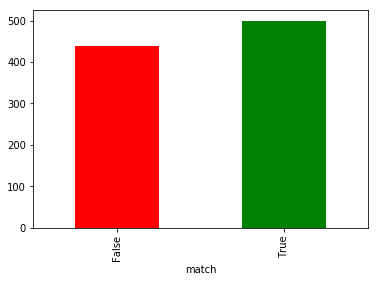

True     500
False    439
Name: match, dtype: int64

In [74]:
# Shows the correct prediction compared to the false ones
(pred_table.groupby(['match']).size().sort_values()).plot(kind='bar', color=['red', 'green'])
plt.show()
pred_table['match'].value_counts()

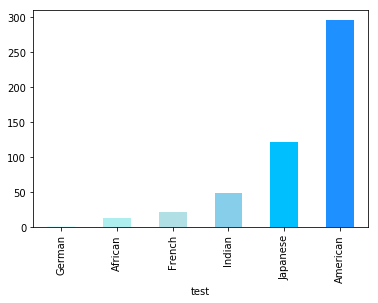

American    295
Japanese    121
Indian       48
French       21
African      13
German        2
Name: test, dtype: int64

In [75]:
# Shows the distribution of correct predictions
pred_table_Matched = pred_table.loc[pred_table['match'] == True]
(pred_table_Matched.groupby(['test']).size().sort_values()).plot(kind='bar', color=['lightcyan','paleturquoise','powderblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue'])
plt.show()
pred_table_Matched['test'].value_counts()

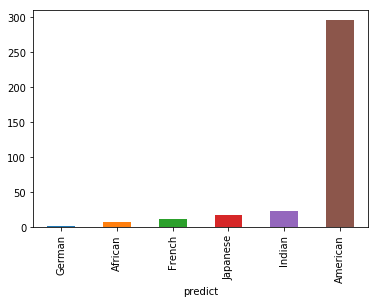

True     295
False     61
Name: match, dtype: int64

In [76]:
#Closer look at the predicted classifications of the American names
pred_table_American = pred_table.loc[pred_table['test'] == 'American']
(pred_table_American.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_American['match'].value_counts()

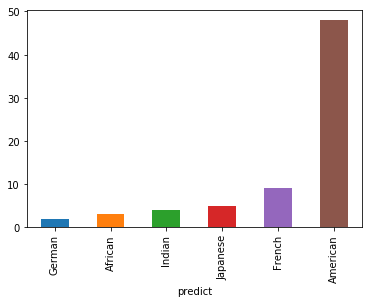

False    69
True      2
Name: match, dtype: int64

In [77]:
#Closer look at the predicted classifications of the German names
pred_table_German = pred_table.loc[pred_table['test'] == 'German']
(pred_table_German.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_German['match'].value_counts()

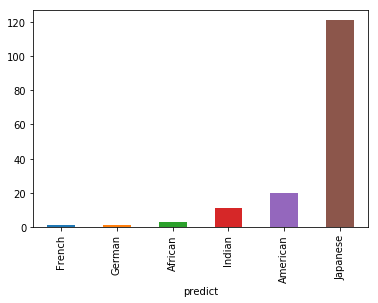

True     121
False     36
Name: match, dtype: int64

In [78]:
#Closer look at the predicted classifications of the Japanese names
pred_table_Japanese = pred_table.loc[pred_table['test'] == 'Japanese']
(pred_table_Japanese.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_Japanese['match'].value_counts()

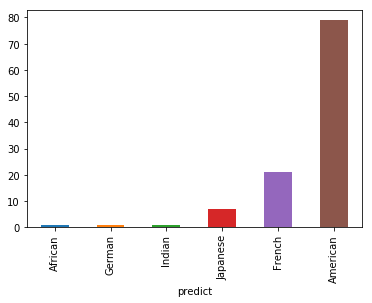

False    89
True     21
Name: match, dtype: int64

In [79]:
#Closer look at the predicted classifications of the French names
pred_table_French = pred_table.loc[pred_table['test'] == 'French']
(pred_table_French.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_French['match'].value_counts()

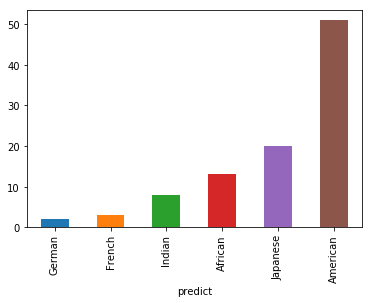

False    84
True     13
Name: match, dtype: int64

In [80]:
#Closer look at the predicted classifications of the African names
pred_table_African = pred_table.loc[pred_table['test'] == 'African']
(pred_table_African.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_African['match'].value_counts()

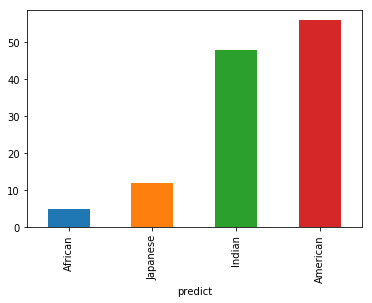

False    73
True     48
Name: match, dtype: int64

In [81]:
#Closer look at the predicted classifications of the Indian names
pred_table_Indian = pred_table.loc[pred_table['test'] == 'Indian']
(pred_table_Indian.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_Indian['match'].value_counts()

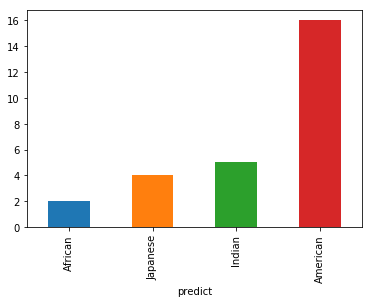

False    27
Name: match, dtype: int64

In [82]:
#Closer look at the predicted classifications of the Russian names
pred_table_Russian = pred_table.loc[pred_table['test'] == 'Russian']
(pred_table_Russian.groupby(['predict']).size().sort_values()).plot(kind='bar')
plt.show()
pred_table_Russian['match'].value_counts()

### Gender Model 

In [83]:
#Split the dataframe into response and explanatory variables
X = name_nation_data["name"].tolist()
labels = name_nation_data["sex"].tolist()

In [84]:
#Split the data into test and training sets to build and fit the model on 
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2)
model = build_model()
model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('cv', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__metric': ['cityblock', 'euclidean'], 'clf__n_neighbors': [2, 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [85]:
#Evaluate the model
pred_table_sex = evaluate_model(model, X_test, Y_test)

0.5921192758253461


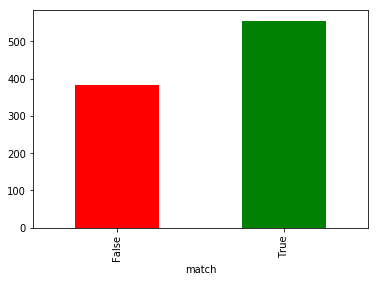

True     556
False    383
Name: match, dtype: int64

In [87]:
# Show the distribution of correct and incorrect predictions
(pred_table_sex.groupby(['match']).size().sort_values()).plot(kind='bar', color=['red','green'])
plt.show()
pred_table_sex['match'].value_counts()

In [88]:
#Closer look at the predicted classifications of the male names
pred_table_male = pred_table_sex.loc[pred_table_sex['test'] == 'Male']
pred_table_male['predict'].value_counts()

Female     196
Male        71
Neutral      6
Name: predict, dtype: int64

In [89]:
#Closer look at the predicted classifications of the female names
pred_table_female = pred_table_sex.loc[pred_table_sex['test'] == 'Female']
pred_table_female['predict'].value_counts()

Female     481
Male        32
Neutral      6
Name: predict, dtype: int64

In [90]:
#Closer look at the predicted classifications of the gender neutral names 
pred_table_neutral = pred_table_sex.loc[pred_table_sex['test'] == 'Neutral']
pred_table_neutral['predict'].value_counts()

Female     117
Male        26
Neutral      4
Name: predict, dtype: int64

Further look at the Japanese names as it performed differently in the model than other nationalities

In [100]:
# Keep only Japanese names and create a list of all the letters used
name_nation_data_Japanese = name_nation_data.loc[name_nation_data['nationality'] == 'Japanese']
JNames = name_nation_data_Japanese["name"].tolist()
l = tokenize(JNames)
JapaneseLetters = [item for sublist in l for item in sublist]

In [104]:
#Letters in Japanese names in order of prevelemce
pd.Series(JapaneseLetters).value_counts()

i    582
a    528
o    508
k    411
u    362
s    266
h    261
m    228
y    205
r    190
t    189
e    179
n    156
c     62
z     49
d     37
j     32
f     25
g     23
b     22
w      8
p      2
l      1
'      1
dtype: int64